<a href="https://colab.research.google.com/github/bominwang/MFMM/blob/main/NHMF_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

用于进行非层级多可信度神经网络建模测试的数学方程

In [73]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

**DEMO1**

包含一个高精度方程和2个低精度方程
输入维度和输出维度均为1，数学表达式为：

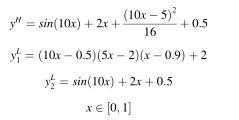

In [74]:
def demo_1(x, index):
  if index == 1:
    y = np.sin(10 * x) + 2 * x + np.power(10 * x -5, 2) / 16 + 0.5
  elif index == 2:
    y = (10 * x - 0.5) * (5 * x - 2) * (x - 0.9) + 2
  else:
    y = np.sin(10 * x) + 2 * x + 0.5
  return y


In [75]:
x = np.linspace(0, 1, 100)
y_h = demo_1(x, 1)
y_l1 = demo_1(x, 2)
y_l2 = demo_1(x, 3)

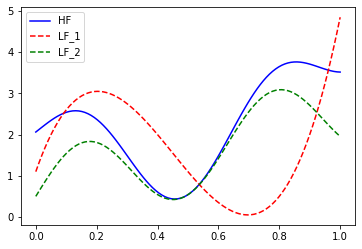

In [76]:
plt.figure(1)
plt.plot(x, y_h, 'b')
plt.plot(x, y_l1, 'r--')
plt.plot(x, y_l2, 'g--')
plt.legend(['HF','LF_1','LF_2'])
plt.show()

In [77]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import Variable

In [78]:
from torch.nn.modules.activation import ReLU
class LFNN(nn.Module):
  def __init__(self):
    super(LFNN, self).__init__()

    self.Input_layer = nn.Sequential(
        nn.Linear(1 ,10),
        nn.BatchNorm1d(10),
        nn.ReLU()
    )
    self.Hidden_layer = nn.Sequential(
        nn.Linear(10,5),
        nn.BatchNorm1d(5),
        nn.ReLU()
    )
    self.Output_layer = nn.Sequential(
        nn.Linear(5,1)
    )
  def forward(self, x):
    x = self.Input_layer(x)
    x = self.Hidden_layer(x)
    y = self.Output_layer(x)
    return y

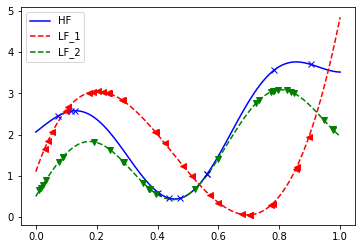

In [79]:
x_1 = np.random.uniform(0, 1, size = (30, 1))
y_1 = demo_1(x_1, 2)
x_2 = np.random.uniform(0, 1, size = (30, 1))
y_2 = demo_1(x_2, 3)
x_h1 = np.random.uniform(0, 1, size = (10, 1))
y_h1 = demo_1(x_h1, 1)
plt.figure(2)
plt.plot(x, y_h, 'b')
plt.plot(x, y_l1, 'r--')
plt.plot(x, y_l2, 'g--')
plt.plot(x_h1, y_h1, 'bx')
plt.plot(x_1, y_1, 'r<')
plt.plot(x_2, y_2, 'gv')
plt.legend(['HF','LF_1','LF_2'])
plt.show()

x_1_t = np.random.uniform(0, 1, size = (30, 1))
y_1_t = demo_1(x_1_t, 2)
x_2_t = np.random.uniform(0, 1, size = (30, 1))
y_2_t = demo_1(x_2_t, 3)
x_h_t = np.random.uniform(0, 1, size = (30, 1))
y_h_t = demo_1(x_h_t, 1)

In [80]:
LF1_model = LFNN().double()
LF2_model = LFNN().double()

训练低精度网络1

In [81]:
batch_size = 100
loss_func = nn.MSELoss()
x_1 = torch.from_numpy(x_1)
y_1 = torch.from_numpy(y_1)
x_1_t = torch.from_numpy(x_1_t)
y_1_t = torch.from_numpy(y_1_t)
optimizer = torch.optim.Adam(LF1_model.parameters(),lr = 0.001)

In [82]:
data = TensorDataset(x_1, y_1)
train_loader = DataLoader(data, batch_size, shuffle = True)
data_test = TensorDataset(x_1_t, y_1_t)
test_loader = DataLoader(data_test, batch_size, shuffle = True)
loss_hist = []
loss_rmse = []
count = 0
for epoch in range(500):
    for i, data in enumerate(train_loader):
        inputs, labs = data
        inputs, labs = Variable(inputs), Variable(labs)
        LF1_model.train()
        l = loss_func(LF1_model(inputs),labs)
        count = count + 1
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        loss_hist.append(loss_func(LF1_model(inputs),labs).item())
    for j, data_t in enumerate(test_loader):
        inputs, outputs = data_t
        inputs, outputs = Variable(inputs), Variable(outputs)
        LF1_model.eval()
        l_t = loss_func(LF1_model(inputs), outputs)
        loss_rmse.append(l_t.item())

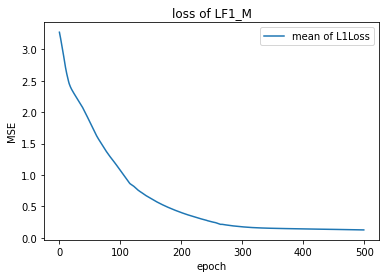

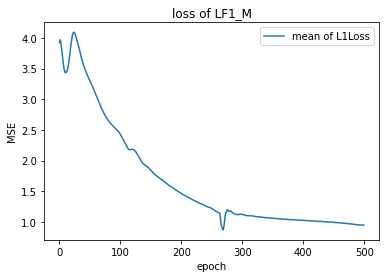

In [83]:
plt.figure(1)
plt.plot(range(len(loss_hist)), loss_hist, label = "mean of L1Loss")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('loss of LF1_M')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(range(len(loss_rmse)), loss_rmse, label = "mean of L1Loss")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('loss of LF1_M')
plt.legend()
plt.show()

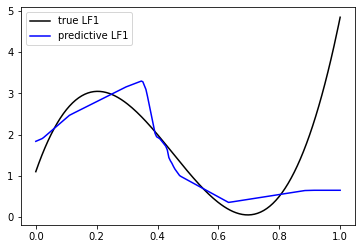

In [84]:
x = np.linspace(0, 1, 200)
y = demo_1(x, 2)
ins = torch.from_numpy(x)
ins = ins.reshape([-1,1])
y_p = LF1_model(ins)
plt.figure(1)
plt.plot(x, y, 'k', label = 'true LF1')
plt.plot(ins, y_p.detach().numpy(), 'b', label = 'predictive LF1')
plt.legend()
plt.show()

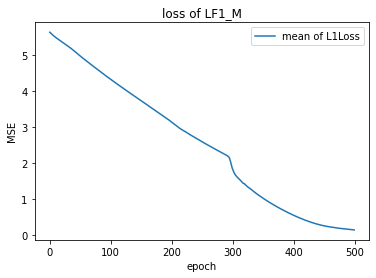

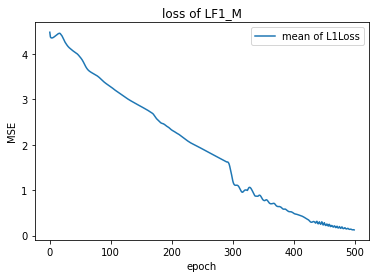

In [85]:
batch_size = 100
loss_func = nn.MSELoss()
x_2 = torch.from_numpy(x_2)
y_2 = torch.from_numpy(y_2)
x_2_t = torch.from_numpy(x_2_t)
y_2_t = torch.from_numpy(y_2_t)
optimizer = torch.optim.Adam(LF2_model.parameters(),lr = 0.001)
data = TensorDataset(x_2, y_2)
train_loader = DataLoader(data, batch_size, shuffle = True)
data_test = TensorDataset(x_2_t, y_2_t)
test_loader = DataLoader(data_test, batch_size, shuffle = True)
loss_hist = []
loss_rmse = []
count = 0
for epoch in range(500):
    for i, data in enumerate(train_loader):
        inputs, labs = data
        inputs, labs = Variable(inputs), Variable(labs)
        LF2_model.train()
        l = loss_func(LF2_model(inputs),labs)
        count = count + 1
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        loss_hist.append(loss_func(LF2_model(inputs),labs).item())
    for j, data_t in enumerate(test_loader):
        inputs, outputs = data_t
        inputs, outputs = Variable(inputs), Variable(outputs)
        LF2_model.eval()
        l_t = loss_func(LF2_model(inputs), outputs)
        loss_rmse.append(l_t.item())
plt.figure(1)
plt.plot(range(len(loss_hist)), loss_hist, label = "mean of L1Loss")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('loss of LF1_M')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(range(len(loss_rmse)), loss_rmse, label = "mean of L1Loss")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('loss of LF1_M')
plt.legend()
plt.show()

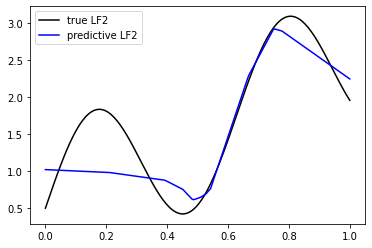

In [86]:
x = np.linspace(0, 1, 200)
y = demo_1(x, 3)
ins = torch.from_numpy(x)
ins = ins.reshape([-1,1])
y_p = LF2_model(ins)
plt.figure(1)
plt.plot(x, y, 'k', label = 'true LF2')
plt.plot(ins, y_p.detach().numpy(), 'b', label = 'predictive LF2')
plt.legend()
plt.show()

In [87]:
class HFNN(nn.Module):
  def __init__(self):
    super(HFNN, self).__init__()

    self.LLayer = nn.Sequential(
        nn.Linear(2, 10),
        nn.BatchNorm1d(10),
        nn.Linear(10, 1)
    )
    self.NLLayer = nn.Sequential(
        nn.Linear(2, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    self.mixed = nn.Linear(2, 1)
    
    self.d_layer = nn.Sequential(
        nn.Linear(1, 10),
        nn.BatchNorm1d(10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    self.outlayer = nn.Linear(2, 1)
  def forward(self,x):

    y1 = self.LLayer(x[:,0:2])
    y2 = self.NLLayer(x[:,0:2])

    y = torch.cat([y1, y2], 1)
    
    y = self.mixed(y)
    
    d = self.d_layer(x[:,2].reshape(-1,1))
    
    ins = torch.cat([y,d], 1)
    
    y = self.outlayer(ins)
    return y

In [88]:
HF_model = HFNN().double()
# train data
x_h1 = np.random.uniform(0, 1, size = (10, 1))
y_h1 = demo_1(x_h1, 1)
# test data
x_h2 = np.random.uniform(0, 1, size = (10, 1))
y_h2 = demo_1(x_h1, 1)

x_h1 = torch.from_numpy(x_h1)
y_h1 = torch.from_numpy(y_h1)
x_h2 = torch.from_numpy(x_h2)
y_h2 = torch.from_numpy(y_h2)

LF1_1 = LF1_model(x_h1)
LF2_1 = LF2_model(x_h1)
LF_11 = torch.cat([LF1_1, LF2_1],1)
LF_11 = torch.cat([LF_11, x_h1],1)
LF1_2 = LF1_model(x_h2)
LF2_2 = LF2_model(x_h2)
LF_22 = torch.cat([LF1_2, LF2_2],1)
LF_22 = torch.cat([LF_22, x_h2], 1)

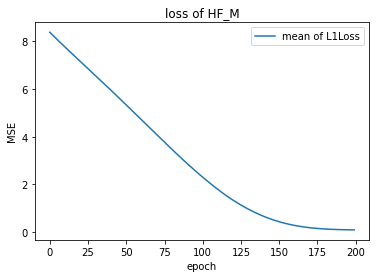

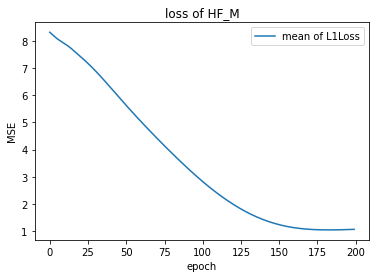

In [89]:
batch_size = 10
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(HF_model.parameters(),lr = 0.001)
data = TensorDataset(LF_11, y_h1)
train_loader = DataLoader(data, batch_size, shuffle = True)
data_test = TensorDataset(LF_22, y_h2)
test_loader = DataLoader(data_test, batch_size, shuffle = True)
loss_hist = []
loss_rmse = []
count = 0
for epoch in range(200):
    for i, data in enumerate(train_loader):
        inputs, labs = data
        inputs, labs = Variable(inputs), Variable(labs)
        HF_model.train()
        inputs = inputs.to(torch.float64)
        pred = HF_model(inputs)
        l = loss_func(pred,labs)
        count = count + 1
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        loss_hist.append(l.item())
    for j, data_t in enumerate(test_loader):
        inputs, outputs = data_t
        inputs, outputs = Variable(inputs), Variable(outputs)
        inputs = inputs.to(torch.float64)
        HF_model.eval()
        l_t = loss_func(HF_model(inputs), outputs)
        loss_rmse.append(l_t.item())
plt.figure(1)
plt.plot(range(len(loss_hist)), loss_hist, label = "mean of L1Loss")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('loss of HF_M')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(range(len(loss_rmse)), loss_rmse, label = "mean of L1Loss")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('loss of HF_M')
plt.legend()
plt.show()

torch.Size([100, 1])


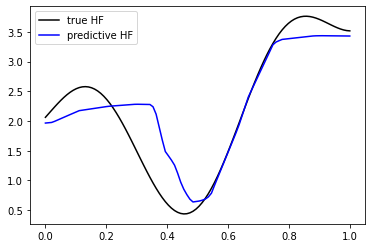

In [90]:
x = np.linspace(0, 1, 100)
y = demo_1(x, 1)
x = x.reshape([-1,1])
x = torch.from_numpy(x)
y1 = LF1_model(x)
y2 = LF2_model(x)
ins = torch.cat([y1, y2],1)
ins = torch.cat([ins, x],1)
ins = ins.to(torch.float64)
y_p = HF_model(ins)
print(y_p.size())
plt.figure(1)
plt.plot(x, y, 'k', label = 'true HF')
plt.plot(x, y_p.detach().numpy(), 'b', label = 'predictive HF')
plt.legend()
plt.show()